# 🧩 Étape 2 — Préparation des données

Ce notebook prépare les données pour l'entraînement du modèle de détection de style de décoration.

## Objectifs de cette étape
- Diviser le dataset en **train (80%)** et **validation (20%)**
- Redimensionner les images en **224×224** pixels (RGB)
- Normaliser les pixels en **[0,1]** (compatible MobileNetV2 + préprocessing ensuite)
- Mettre en place une **augmentation de données** réaliste
- Créer des **datasets TensorFlow** prêts pour l'entraînement
- Visualiser quelques **batchs augmentés** pour vérification


## 1. Imports et configuration de base


In [1]:
import os
from pathlib import Path

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

print(tf.__version__)

# Style des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


d:\Program Files\Python313\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


2.20.0


## 2. Définition des chemins et paramètres globaux


In [ ]:
# Chemin vers le dataset (même structure que dans 01_data_exploration)
DATASET_DIR = Path("../dataset")

# Correspondance noms de dossiers (FR) -> labels (EN) utilisés par le modèle
STYLE_MAPPING = {
    'boheme': 'bohemian',
    'royal': 'royal',
    'minimaliste': 'minimalist',
    'rustique': 'rustic',
    'vintage': 'vintage',
    'moderne': 'modern',
    'industriel': 'industrial',
}

IMG_SIZE = (224, 224)   # MobileNetV2 input (224x224 - taille standard optimisée)
BATCH_SIZE = 32
SEED = 42
VAL_SPLIT = 0.2

print(f"Dataset dir: {DATASET_DIR.resolve()}")
print(f"Existe: {DATASET_DIR.exists()}")


Dataset dir: D:\Computer-Vision\Computer-vision-project\dataset
Existe: True


## 3. Création des datasets train / validation (split 80/20)

On utilise `tf.keras.utils.image_dataset_from_directory` qui :
- lit directement les images à partir de la structure de dossiers
- crée automatiquement les labels à partir des noms de sous-dossiers
- gère le split **train/validation** de manière reproductible.


In [3]:
# IMPORTANT : la structure doit être dataset/<style_fr>/*.jpg
assert DATASET_DIR.exists(), "Le dossier dataset/ n'existe pas à l'emplacement attendu."

# Création du dataset d'entraînement
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    labels="inferred",            # labels = noms de dossiers
    label_mode="categorical",    # vecteurs one-hot pour 7 classes
    validation_split=VAL_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

# Création du dataset de validation
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    labels="inferred",
    label_mode="categorical",
    validation_split=VAL_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

class_names_raw = train_ds.class_names
print("Classes détectées par Keras (dossiers) :", class_names_raw)

# Map dossiers FR -> labels EN cohérents avec le reste du projet
class_names_en = [STYLE_MAPPING.get(name, name) for name in class_names_raw]
print("Labels (EN) utilisés pour le modèle :", class_names_en)

NUM_CLASSES = len(class_names_en)
print("Nombre de classes :", NUM_CLASSES)


Found 41332 files belonging to 7 classes.
Using 33066 files for training.
Found 41332 files belonging to 7 classes.
Using 8266 files for validation.
Classes détectées par Keras (dossiers) : ['boheme', 'industriel', 'minimaliste', 'moderne', 'royal', 'rustique', 'vintage']
Labels (EN) utilisés pour le modèle : ['bohemian', 'industrial', 'minimalist', 'modern', 'royal', 'rustic', 'vintage']
Nombre de classes : 7


## 4. Optimisation des datasets (cache, shuffle, prefetch)

On optimise le pipeline pour :
- éviter de relire à chaque epoch (`cache`)
- mélanger les batchs d'entraînement (`shuffle`)
- précharger les batchs sur CPU pendant que le GPU s'entraîne (`prefetch`).


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Optimisation du pipeline (SANS CACHE pour économiser RAM)
train_ds = (
    train_ds
    .shuffle(1000, seed=SEED, reshuffle_each_iteration=True)
    .prefetch(buffer_size=AUTOTUNE)
)

val_ds = (
    val_ds
    .prefetch(buffer_size=AUTOTUNE)
)

print("✅ Datasets optimisés prêts pour l'entraînement.")
print("   (Pipeline sans cache pour économiser la RAM)")


Datasets optimisés prêts pour l'entraînement.


## 5. Couche de normalisation et augmentation de données

**Important :**
- Les pixels bruts sont dans \([0, 255]\).
- On les **normalise en [0,1]** puis on appliquera plus tard le préprocessing spécifique à MobileNetV2 (dans le modèle).

L’augmentation de données doit :
- refléter des variations réalistes sur des photos d’événements
- ne pas déformer complètement la scène (éviter des rotations de 90° par exemple).


In [ ]:
# Couche de mise à l'échelle [0,255] -> [0,1]
normalization_layer = layers.Rescaling(1./255)

# Pipeline d'augmentation de données SIMPLIFIÉE
# (sera utilisé uniquement sur le train, pas sur la validation)
# Simplifiée pour économiser la RAM tout en gardant une bonne régularisation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),               # symétrie horizontale
    layers.RandomRotation(0.1),                     # rotations (~±18°)
    layers.RandomZoom(0.1),                        # léger zoom
], name="data_augmentation")

# Note : Ces couches seront intégrées directement dans le modèle
# pour être automatiquement désactivées en validation


## 6. Visualisation de quelques images (avant / après augmentation)

Cette étape est **critique** pour vérifier que :
- les labels correspondent bien à la bonne classe
- l’augmentation ne détruit pas les patterns visuels importants (textures, compositions…)
- les images sont correctement redimensionnées (224×224).


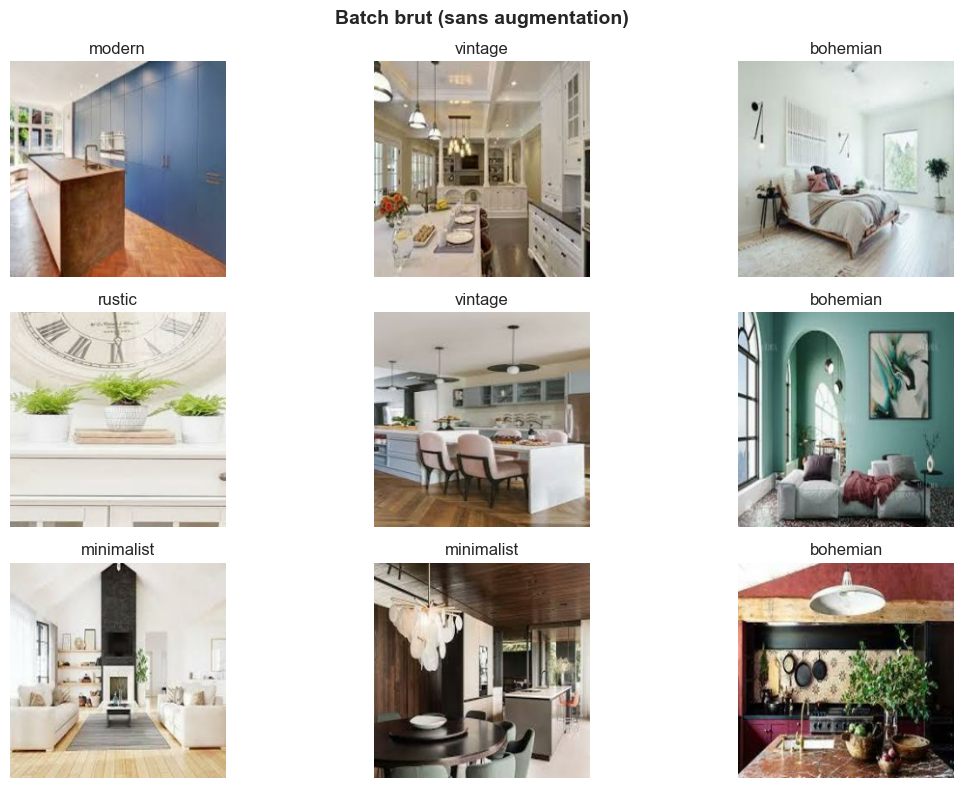

In [6]:
def show_batch(dataset, title="Batch brut (sans augmentation)"):
    images, labels = next(iter(dataset))
    images = images.numpy().astype("uint8")
    labels_idx = np.argmax(labels.numpy(), axis=1)

    plt.figure(figsize=(12, 8))
    for i in range(9):
        if i >= len(images):
            break
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names_en[labels_idx[i]])
        plt.axis("off")
    plt.suptitle(title, fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()

show_batch(train_ds)


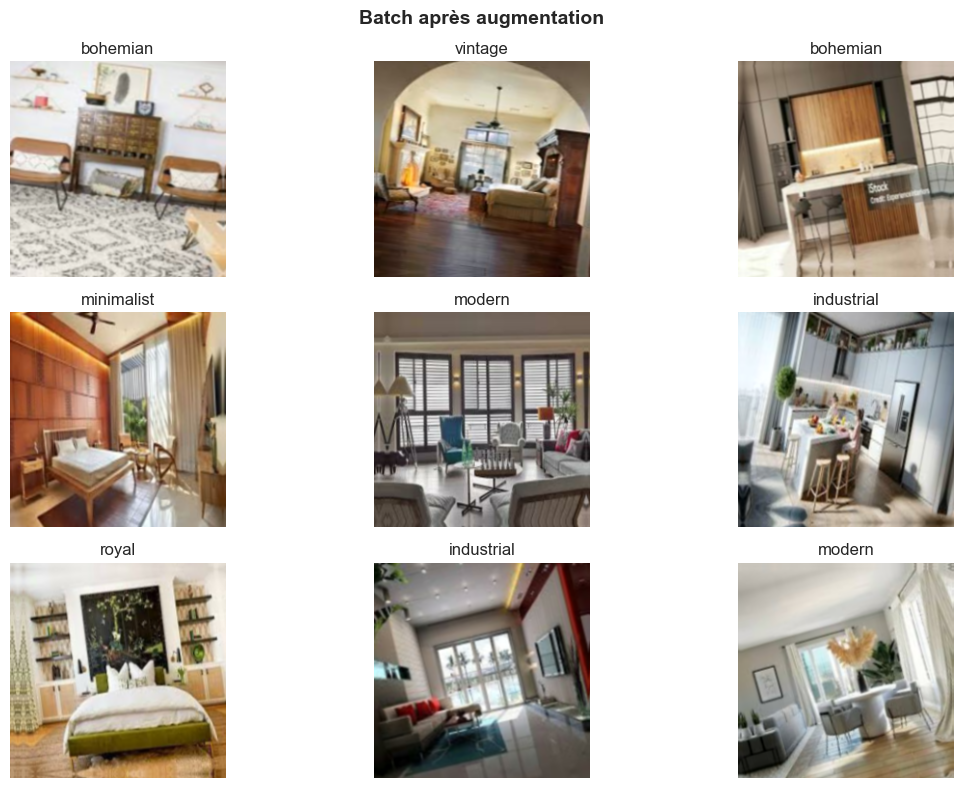

In [7]:
# Visualisation après normalisation + augmentation

def show_augmented_batch(dataset, title="Batch après augmentation"):
    images, labels = next(iter(dataset))
    # Normalisation [0,1]
    images = normalization_layer(images)
    # Augmentation
    images = data_augmentation(images, training=True)
    images = tf.clip_by_value(images, 0.0, 1.0)
    images_np = (images.numpy() * 255).astype("uint8")

    labels_idx = np.argmax(labels.numpy(), axis=1)

    plt.figure(figsize=(12, 8))
    for i in range(9):
        if i >= len(images_np):
            break
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images_np[i])
        plt.title(class_names_en[labels_idx[i]])
        plt.axis("off")
    plt.suptitle(title, fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()

show_augmented_batch(train_ds)


## 7. Sauvegarde de la configuration et des classes

On sauvegarde maintenant :
- la liste des classes en anglais (ordre exact des sorties du modèle)
- les principaux hyperparamètres de préparation des données

Cela permettra de :
- reconstruire le modèle et les prédictions **dans le même ordre de classes**
- exposer les labels corrects dans l’API plus tard.


In [8]:
import json

config = {
    "img_size": list(IMG_SIZE),
    "batch_size": BATCH_SIZE,
    "val_split": VAL_SPLIT,
    "seed": SEED,
    "class_names_raw": class_names_raw,
    "class_names_en": class_names_en,
}

models_dir = Path("../models")
models_dir.mkdir(exist_ok=True)

config_path = models_dir / "data_config.json"
with open(config_path, "w", encoding="utf-8") as f:
    json.dump(config, f, indent=2, ensure_ascii=False)

print(f"Configuration sauvegardée dans: {config_path.resolve()}")


Configuration sauvegardée dans: D:\Computer-Vision\Computer-vision-project\models\data_config.json


## 8. Récapitulatif de l'étape 2

À ce stade, vous devez avoir :

- ✅ Un split **train (80%) / validation (20%)** reproductible
- ✅ Des images redimensionnées en **224×224** avec 3 canaux (RGB)
- ✅ Des labels **one-hot** pour 7 classes dans le bon ordre
- ✅ Un pipeline d’augmentation réaliste pour le train
- ✅ Un pipeline de normalisation [0,1]
- ✅ Des visualisations de batchs bruts et augmentés
- ✅ Un fichier `data_config.json` dans `models/`

Nous pourrons maintenant passer à l’**Étape 3 — Construction du modèle (MobileNetV2 + couches de classification)**.
